# **decision tree / random Forest**


In [26]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split
from sklearn.tree import DecisionTreeRegressor

df=pd.read_csv('Carbon_Emission.csv',sep=";")

# change display settings to show all columns
pd.set_option('display.max_columns', None)

# rename columns: replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_')

df.head()

,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


#  Data Validation

in simulating the data set the creators seemed to have linked the use of a cooking with grill and the use of an airfryer. Consequently, we excluded the airfryer from the variables, as it did not contain any additional information. We found this out by doing a correlation matrix for the dummy-variables.

In [27]:

# Remove "Airfryer" from the 'Cooking_With'-variable
df['Cooking_With'] = df['Cooking_With'].str.replace(", 'Airfryer'", "") 

# Check if the removal was successful
unique_values_cooking_With= set([item for sublist in df['Cooking_With'].unique() for item in eval(sublist)]) # Create a set of all unique "Cooking_With" options
print(unique_values_cooking_With)   

{'Grill', 'Oven', 'Microwave', 'Stove'}


# sorting the variables into groups


| variable type| variables | encoding  |
| -----------  | ----------- | ----------- |
| target variable |  CarbonEmission |   |
| Quantitative Variables |  Monthly Grocery Bill, Vehicle Monthly Distance Km, Waste Bag Weekly Count, How Long TV, PC Daily, Hour How Many New Clothes Monthly, How Long Internet Daily Hour |   |
| Ordinal Variables | Body_Type, Diet, How_Often_Shower, Social_Activity, Frequency_of_Traveling_by_Air, Waste_Bag_Size, Energy_efficiency | OrdinalEncoder (*) |
| Nominal Variables, with one answer | 'Sex', 'Heating_Energy_Source', 'Transport', 'Vehicle Type' | OneHotEncoder (drop 'Sex_female' and drop NaN in 'Vehicle Type') |
| Nominal Variables, with multiple (or zero) answers  | Recycling, Cooking_With | OneHotEncoder |

(*) we want for Body-type:'underweight'=0, 'normal'=1, 'overweight'=2, 'obese'=3. with OrdinalEncoder of Scikit-learn we get: normal: 0, obese: 1, overweight: 2, underweigt: 3 - that would be wrong. chatGPT said there is no tool in Scikit-learn to help me so i do the encoding manually

# Encoding

### Encoding: ordinal variables

In [28]:
#ordering values of ordinal variables
dict_variables_ordinal_categorical = {
    'Body_Type': ['underweight', 'normal', 'overweight', 'obese'],
    'Diet': ['vegan','vegetarian','pescatarian','omnivore'],
    'How_Often_Shower': ['less frequently','daily', 'twice a day','more frequently'],
    'Social_Activity': ['never', 'sometimes','often'],
    'Frequency_of_Traveling_by_Air': ['never', 'rarely', 'frequently', 'very frequently'],
    'Waste_Bag_Size': ['small','medium', 'large', 'extra large'],
    'Energy_efficiency': ['Yes', 'Sometimes', 'No']
}

df.tail()

,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission
9995,obese,male,omnivore,twice a day,coal,private,hybrid,sometimes,230,never,268,medium,5,12,27,9,Yes,[],['Microwave'],2408
9996,normal,female,vegan,twice a day,coal,private,lpg,never,234,frequently,5316,extra large,3,14,8,24,Sometimes,"['Paper', 'Plastic']","['Stove', 'Microwave']",3084
9997,overweight,female,vegetarian,daily,electricity,walk/bicycle,NaN,sometimes,298,very frequently,96,extra large,5,11,5,24,Yes,"['Paper', 'Plastic', 'Metal']","['Microwave', 'Grill']",2377
9998,underweight,male,vegan,more frequently,coal,private,petrol,often,179,rarely,8688,medium,5,19,14,5,Sometimes,"['Paper', 'Metal']","['Stove', 'Microwave', 'Grill']",4574
9999,obese,male,pescatarian,twice a day,wood,private,electric,sometimes,115,never,9952,small,4,11,6,0,Sometimes,"['Plastic', 'Glass', 'Metal']","['Oven', 'Grill']",826


In [29]:
# error-potential: this makes NaN if run a second time 

# Custom mapping for ordinal encoding based on defined order
for column, column_ordering in dict_variables_ordinal_categorical.items():
   mapping = {category: idx for idx, category in enumerate(column_ordering)}
   df[column] = df[column].map(mapping)
df.tail()

,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission
9995,3,male,3,2,coal,private,hybrid,1,230,0,268,1,5,12,27,9,0,[],['Microwave'],2408
9996,1,female,0,2,coal,private,lpg,0,234,2,5316,3,3,14,8,24,1,"['Paper', 'Plastic']","['Stove', 'Microwave']",3084
9997,2,female,1,1,electricity,walk/bicycle,NaN,1,298,3,96,3,5,11,5,24,0,"['Paper', 'Plastic', 'Metal']","['Microwave', 'Grill']",2377
9998,0,male,0,3,coal,private,petrol,2,179,1,8688,1,5,19,14,5,1,"['Paper', 'Metal']","['Stove', 'Microwave', 'Grill']",4574
9999,3,male,2,2,wood,private,electric,1,115,0,9952,0,4,11,6,0,1,"['Plastic', 'Glass', 'Metal']","['Oven', 'Grill']",826


### dummy variables for: 'Sex', 'Heating_Energy_Source', 'Transport', 'Vehicle Type' 

In [30]:
#makes an error if run 2 times because original columns are gone

#creaty dummy-variables
df = pd.get_dummies(df, columns=['Sex'], drop_first=True) #drop of first column
df = pd.get_dummies(df, columns=['Transport', 'Heating_Energy_Source']) 
df = pd.get_dummies(df, columns=['Vehicle_Type'], dummy_na=False)  #dummy_na=False: Prevents the creation of dummy variables for NaN values.


df.head()

,Body_Type,Diet,How_Often_Shower,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission,Sex_male,Transport_private,Transport_public,Transport_walk/bicycle,Heating_Energy_Source_coal,Heating_Energy_Source_electricity,Heating_Energy_Source_natural gas,Heating_Energy_Source_wood,Vehicle_Type_diesel,Vehicle_Type_electric,Vehicle_Type_hybrid,Vehicle_Type_lpg,Vehicle_Type_petrol
0,2,2,1,2,230,2,210,2,4,7,26,1,2,['Metal'],"['Stove', 'Oven']",2238,False,False,True,False,True,False,False,False,False,False,False,False,False
1,3,1,0,2,114,1,9,3,3,9,38,5,2,['Metal'],"['Stove', 'Microwave']",1892,False,False,False,True,False,False,True,False,False,False,False,False,False
2,2,3,3,0,138,0,2472,0,1,14,47,6,1,['Metal'],"['Oven', 'Microwave']",2595,True,True,False,False,False,False,False,True,False,False,False,False,True
3,2,3,2,1,157,1,74,1,3,20,5,7,1,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill']",1074,True,False,False,True,False,False,False,True,False,False,False,False,False
4,3,1,1,2,266,3,8457,2,1,3,5,6,0,['Paper'],['Oven'],4743,False,True,False,False,True,False,False,False,True,False,False,False,False


### OneHotEncoding for Multi-Select Features ("Recycling" and "Cooking_With")

In [31]:
# Function to create dummy variables for a given column that has multi-select features
def create_dummy_variables(df, column_name):

    # Extract unique values from the column
    unique_values = {item for sublist in df[column_name].unique() for item in eval(sublist)}
    
    # Create dummy variables for each unique value
    for item in unique_values:
        df[f'{column_name}_{item}'] = df[column_name].apply(lambda x: 1 if item in x else 0)
    
    # Drop the original column after creating dummy variables
    df = df.drop([column_name], axis=1)

    return df


# Generate dummy variables for Recycling and Cooking_With columns
df = create_dummy_variables(df, 'Recycling')
df = create_dummy_variables(df, 'Cooking_With')


df.head()

,Body_Type,Diet,How_Often_Shower,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,CarbonEmission,Sex_male,Transport_private,Transport_public,Transport_walk/bicycle,Heating_Energy_Source_coal,Heating_Energy_Source_electricity,Heating_Energy_Source_natural gas,Heating_Energy_Source_wood,Vehicle_Type_diesel,Vehicle_Type_electric,Vehicle_Type_hybrid,Vehicle_Type_lpg,Vehicle_Type_petrol,Recycling_Paper,Recycling_Metal,Recycling_Glass,Recycling_Plastic,Cooking_With_Grill,Cooking_With_Oven,Cooking_With_Microwave,Cooking_With_Stove
0,2,2,1,2,230,2,210,2,4,7,26,1,2,2238,False,False,True,False,True,False,False,False,False,False,False,False,False,0,1,0,0,0,1,0,1
1,3,1,0,2,114,1,9,3,3,9,38,5,2,1892,False,False,False,True,False,False,True,False,False,False,False,False,False,0,1,0,0,0,0,1,1
2,2,3,3,0,138,0,2472,0,1,14,47,6,1,2595,True,True,False,False,False,False,False,True,False,False,False,False,True,0,1,0,0,0,1,1,0
3,2,3,2,1,157,1,74,1,3,20,5,7,1,1074,True,False,False,True,False,False,False,True,False,False,False,False,False,1,1,1,1,1,0,1,0
4,3,1,1,2,266,3,8457,2,1,3,5,6,0,4743,False,True,False,False,True,False,False,False,True,False,False,False,False,1,0,0,0,0,1,0,0


# model: Decision Tree Regression

#### make the model

In [32]:
X = df.drop(["CarbonEmission"],axis=1)

y = df["CarbonEmission"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y,train_size=0.75,)

clf = GridSearchCV(DecisionTreeRegressor(), param_grid = {
    'max_depth': [9,12,15],
    'min_samples_leaf': [30,50] #werden nicht mehr aufgeteilt wenn nur noch x Leute noch drinnen sind
}, cv = RepeatedKFold(n_splits = 4)) 

clf.fit(X_train2, y_train2)

clf

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=4, random_state=None),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [9, 12, 15],
                         'min_samples_leaf': [30, 50]})

#### evaluate 

In [13]:
  ##Evaluating the Model  ######################################################
from sklearn.metrics import mean_squared_error, r2_score

# Predict the target variable for the training and test sets
y_train_pred2 = clf.predict(X_train2)
y_test_pred2 = clf.predict(X_test2)

# Create a DataFrame with the results
pd.DataFrame({
    'R-squared': [
        r2_score(y_train2, y_train_pred2),
        r2_score(y_test2, y_test_pred2)
    ],
    'Mean Squared Error': [
        mean_squared_error(y_train2, y_train_pred2),
        mean_squared_error(y_test2, y_test_pred2)
    ]
}, index=['Training Set Evaluation', 'Test Set Evaluation'])

,R-squared,Mean Squared Error
Training Set Evaluation,0.874662,130201.437612
Test Set Evaluation,0.837363,166837.243411


In [14]:
DecisionTreeRegressor?

Init signature:
DecisionTreeRegressor(
    *,
    criterion='squared_error',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,
    monotonic_cst=None,
)
Docstring:     
A decision tree regressor.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"squared_error", "friedman_mse", "absolute_error",             "poisson"}, default="squared_error"
    The function to measure the quality of a split. Supported criteria
    are "squared_error" for the mean squared error, which is equal to
    variance reduction as feature selection criterion and minimizes the L2
    loss using the mean of each terminal node, "friedman_mse", which uses
    mean squared error with Friedman's improvement score for potential
    splits, "absolute_error" for the mean absolute error, which minim

In [15]:
#Hyperparameter
pd.DataFrame(clf.cv_results_)[['mean_test_score','param_max_depth','param_min_samples_leaf','rank_test_score']]

,mean_test_score,param_max_depth,param_min_samples_leaf,rank_test_score
0,0.822084,9,30,3
1,0.808279,9,50,6
2,0.823579,12,30,2
3,0.808600,12,50,4
4,0.823581,15,30,1
5,0.808600,15,50,4


#### see the tree

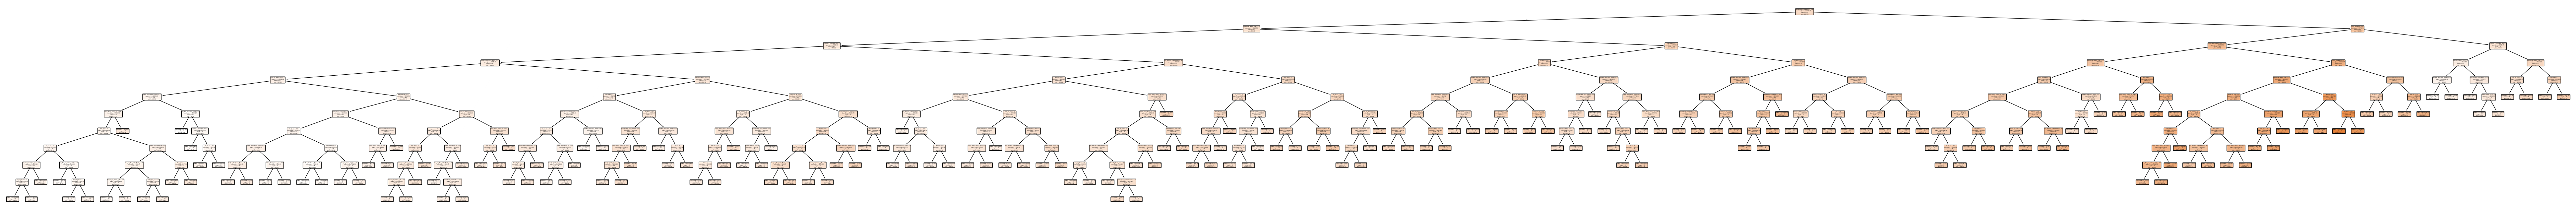

In [16]:
#chatGPT did the programming for me

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


#ich bin mir nicht sicher ob das hier stimmt!!!
# Beste Parameter aus GridSearchCV verwenden
best_model = clf.best_estimator_

# Plot the decision tree
plt.figure(figsize=(100, 8))
plot_tree(best_model, filled=True, feature_names=X.columns, rounded=True)
plt.show()



### prediction

In [ ]:
#for (max_depth=3, min_samples_leaf=5) - people in the 2nd box from the right:
filtered_df = df[
    (df['Vehicle_Monthly_Distance_Km'] > 3219) &
    (df['Vehicle_Type'] == 'electric') &
    (df['Frequency_of_Traveling_by_Air'] <= 1.5)
]

# loc[:, X.columns] = Select the relevant columns based on X.columns  - otherwise i will get an error-message
X_pred = filtered_df.loc[:, X.columns].head()
y_pred = model.predict(X_pred)
print("Predicted CarbonEmission: ", y_pred)
filtered_df.head()

### save the model in pkl-format

In [ ]:
# chatGPT did the programming

import pickle

#with open('encoder_decision_tree.pkl', 'wb') as cf_file: #ColumnTransformers 
#    pickle.dump(cf, cf_file)

#with open('model_decision_tree.pkl', 'wb') as model_file: #Modell
#    pickle.dump(model, model_file)